In [1]:
import sys 
sys.path.insert(0, "../../src")
from normalizevideos import CURRENT_DIR, data_dir

from CorInfoMaxBSS import OnlineCorInfoMax, CorInfoMaxVideoSeparation
from general_utils import display_matrix
from bss_utils import ZeroOneNormalizeColumns
from visualization_utils import Subplot_RGB_images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import pylab as pl
from tqdm import tqdm
from IPython.display import display, Latex, Math, clear_output
from IPython import display as display1
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import zipfile

FRAMES = 300

In [2]:
ship_img = []
bird_img = []
guitar_img = []

for i in range(FRAMES):
    ship_img.append(mpimg.imread(os.path.join(CURRENT_DIR, "Frames", "SHIP", f"{i+1}.jpg")))
    bird_img.append(mpimg.imread(os.path.join(CURRENT_DIR, "Frames", "BIRD", f"{i+1}.jpg")))
    guitar_img.append(mpimg.imread(os.path.join(CURRENT_DIR, "Frames", "GUITAR", f"{i+1}.jpg")))

ship_img = np.array(ship_img)
bird_img = np.array(bird_img)
guitar_img = np.array(guitar_img)

In [3]:
frame_sizes = [360, 640]
ship_image_shape = ship_img.shape
bird_image_shape = bird_img.shape
guitar_image_shape = guitar_img.shape
# An array to hold the corresponding frames of the videos
# for ex: [bird_img[0], drift_img[0], guitar_img[0]]
same_frame = []
small_images = []
for i in tqdm(range(FRAMES)):
    ship_img_ = cv2.resize(ship_img[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=frame_sizes[0]/ship_image_shape[1],
                           fy=frame_sizes[1]/ship_image_shape[2], 
                           interpolation=cv2.INTER_NEAREST)
    
    bird_img_ = cv2.resize(bird_img[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=frame_sizes[0]/bird_image_shape[1],
                           fy=frame_sizes[1]/bird_image_shape[2], 
                           interpolation=cv2.INTER_NEAREST)
    
    guitar_img_ = cv2.resize(guitar_img[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=frame_sizes[0]/guitar_image_shape[1],
                           fy=frame_sizes[1]/guitar_image_shape[2], 
                           interpolation=cv2.INTER_NEAREST)
    
    same_frame.append([ship_img_, bird_img_, guitar_img_])
    small_images.append([same_frame[i][0].reshape(-1,)/255, same_frame[i][1].reshape(-1,)/255, same_frame[i][2].reshape(-1,)/255])
    
small_images = np.array(small_images)
print(small_images.shape)

100%|██████████| 300/300 [00:03<00:00, 83.13it/s]


(300, 3, 691200)


In [4]:
test_s = small_images[0][[0, 1, 2]]
print("Coefficient Correlation Matrix of the first frames:")
display_matrix(np.corrcoef(test_s))

Coefficient Correlation Matrix of the first frames:


<IPython.core.display.Math object>

In [5]:
# Take three sources and create six mixtures
n_mixtures = 6
n_sources = 3

np.random.seed(100)

A = np.random.standard_normal((n_mixtures, n_sources))
minA = np.min(A)
min_abs = np.abs(minA)

for i in range(n_mixtures):
    for j in range(n_sources):
        if A[i, j] <= 0:
            A[i, j] += min_abs + 0.1
        elif A[i, j] + minA >= 0:
            A[i, j] += minA
        
# A = ortho_group.rvs(3) # Make it an orthogonal matrix instead
# A = np.random.uniform(0.1, 2, (n_mixtures, n_sources))

print(f"Mixture Matrix:")
display_matrix(A)

Mixture Matrix:


<IPython.core.display.Math object>

In [6]:
X_arr = [] # Mixtures for each frame
X_plot_arr = []
S_arr = [] # Keeps the three S matrices

for i in tqdm(range(FRAMES)):
    temp = []

    s = small_images[i][[0, 1, 2]]
    S = s
    S_arr.append(S)

    X = A @ S

    X_plot_arr.append(ZeroOneNormalizeColumns(X.T).T)
    temp.append(X)
    
    X_arr.append(np.array(temp))

X_arr = np.array(X_arr)
X_arr = X_arr.reshape(FRAMES, n_mixtures, 691200)
S_arr = np.array(S_arr)
X_plot_arr = np.array(X_plot_arr)
S_plot_arr = ZeroOneNormalizeColumns(S_arr)
print(X_arr.shape)
print(S_arr.shape)
print(X_plot_arr.shape)
print(S_plot_arr.shape)

100%|██████████| 300/300 [00:21<00:00, 14.00it/s]


(300, 6, 691200)
(300, 3, 691200)
(300, 6, 691200)
(300, 3, 691200)


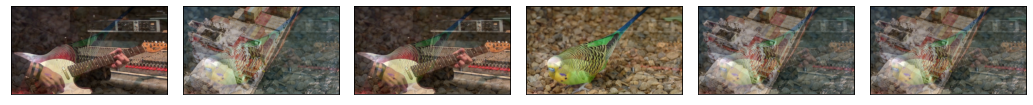

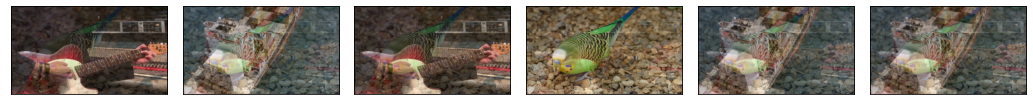

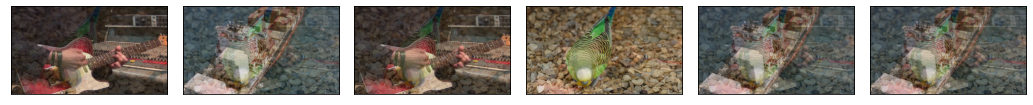

In [7]:
Subplot_RGB_images(X_plot_arr[60], imsize = [360, 640], height=3, width=15) # Second 2
Subplot_RGB_images(X_plot_arr[120], imsize = [360, 640], height=3, width=15) # Second 4
Subplot_RGB_images(X_plot_arr[180], imsize = [360, 640], height=3, width=15) # Second 6

# Saving 3 Mixture Videos

In [8]:
mix_dir = os.path.join(CURRENT_DIR, "Mix-Videos")
if not os.path.exists(mix_dir):
    os.mkdir(mix_dir)
mix1 = cv2.VideoWriter(os.path.join(mix_dir, "mix1.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
mix2 = cv2.VideoWriter(os.path.join(mix_dir, "mix2.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
mix3 = cv2.VideoWriter(os.path.join(mix_dir, "mix3.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))

for i in tqdm(range(FRAMES)):
    mix1.write(cv2.normalize(cv2.cvtColor(X_plot_arr[i][0].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
    mix2.write(cv2.normalize(cv2.cvtColor(X_plot_arr[i][1].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
    mix3.write(cv2.normalize(cv2.cvtColor(X_plot_arr[i][2].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))

mix1.release()
mix2.release()
mix3.release()

100%|██████████| 300/300 [00:04<00:00, 65.17it/s]


In [9]:
# class LDMIVid(OnlineCorInfoMax):
    
#     def seperate_videos(self, Wf_list, X, imsize = [360, 640], n_pixel_per_frame=5, 
#                         n_iter = 1000000, neural_dynamic_iterations = 250, 
#                         neural_lr_start = 0.9, neural_lr_stop = 1e-3, 
#                         neural_loop_lr_rule="divide_by_loop_index",
#                         neural_lr_decay_multiplier=0.005,
#                         use_error_corr_structured_connectivity=False,
#                         shuffle=False,
#                         debug_iteration_point=1000,
#                         plot_in_jupyter=False,):
        
#         lambday, lambdae, muW, gamy, game, W, By, Be = (
#             self.lambday,
#             self.lambdae,
#             self.muW,
#             self.gamy,
#             self.game,
#             self.W,
#             self.By,
#             self.Be,
#         )        
#         neural_dynamic_tol = self.neural_OUTPUT_COMP_TOL
#         debugging = self.set_ground_truth
#         number_of_mixtures = X.shape[1]
#         number_of_frames = X.shape[0]

        
#         samples = X.shape[2]
                
#         if debugging:
#             SIRlist = []
#             A = self.A
            
#         sample_counter = 0
#         for i_sample in tqdm(range(n_iter)):
#             x_current = X_arr[np.mod(sample_counter // n_pixel_per_frame, 10),:, np.random.randint(samples)]
#             y = np.zeros(self.s_dim)

#             y = self.run_neural_dynamics_nnantisparse(
#                                                     x_current,
#                                                     y,
#                                                     W,
#                                                     By,
#                                                     Be,
#                                                     gamy,
#                                                     game,
#                                                     lr_start=neural_lr_start,
#                                                     lr_stop=neural_lr_stop,
#                                                     lr_rule=neural_loop_lr_rule,
#                                                     lr_decay_multiplier=neural_lr_decay_multiplier,
#                                                     neural_dynamic_iterations=neural_dynamic_iterations,
#                                                     neural_OUTPUT_COMP_TOL=neural_dynamic_tol,
#                                                 )

#             e = y - W @ x_current

#             W = W + muW * np.outer(e, x_current)

#             z = By @ y
#             By = (1/lambday) * (By - gamy * np.outer(z, z))
            
#             if debugging:
#                 if (i_sample % debug_iteration_point) == 0:
#                     self.W = W
#                     self.By = By
#                     self.Be = Be
#                     Wf = self.compute_overall_mapping(return_mapping = True)
#                     Wf_list.append(Wf)
#                     SIR = self.CalculateSIR(A, Wf)[0]
#                     SIRlist.append(SIR)
#                     self.SIR_list = SIRlist
#                     if plot_in_jupyter:
#                         pl.clf()
#                         pl.plot(np.array(SIRlist), linewidth = 3)
#                         pl.xlabel("Number of Iterations / {}".format(debug_iteration_point), fontsize = 15)
#                         pl.ylabel("SIR (dB)", fontsize = 15)
#                         pl.title("SIR Behaviour", fontsize = 15)
#                         pl.grid()
#                         clear_output(wait=True)
#                         display(pl.gcf())   
#             sample_counter += 1
#         return X

In [10]:
lambday = 1 - 1e-1/5
lambdae = 0.3

s_dim = S.shape[0]
x_dim = X.shape[0]

n_iter = 352500
ppf = 20
Wf_arr = []

# Inverse output covariance
By = 1 * np.eye(s_dim)
# Inverse error covariance
Be = 65 * np.eye(s_dim)

debug_iteration_point = n_iter // (FRAMES - 1)
model = CorInfoMaxVideoSeparation(  s_dim = s_dim, x_dim = x_dim, muW = 60*1e-3, lambday = lambday,
                                    lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                                    set_ground_truth = True, S = S, A = A)

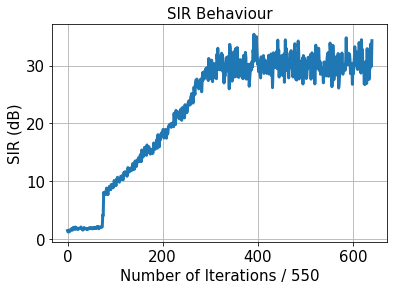

100%|██████████| 352500/352500 [03:32<00:00, 1654.96it/s]


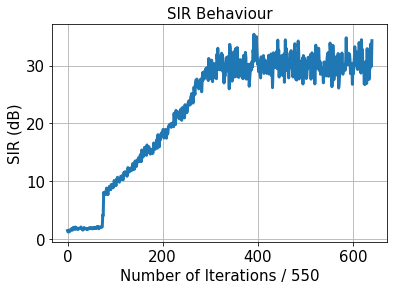

In [11]:
aa = model.seperate_videos(Wf_list = Wf_arr, n_pixel_per_frame=ppf, X = X_arr, 
                           n_iter = n_iter, neural_dynamic_iterations = 500,
                           plot_in_jupyter = True, neural_lr_start = 0.25,
                           neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                           shuffle = True)

In [12]:
model.SIR_list[299]

30.3179485488743

In [13]:
X = X_arr[0]
S = S_arr[0]
# Wf = model.compute_overall_mapping(return_mapping = True)
Wf_arr = np.array(Wf_arr)
Y = Wf_arr[-1] @ X
Y.shape, X.shape, S.shape, Wf_arr.shape

((3, 691200), (6, 691200), (3, 691200), (641, 3, 6))

In [14]:
Y_reconstructed_frames = [ZeroOneNormalizeColumns(-(Wf_arr[i] @ X_arr[i,:,:]).T).T for i in tqdm(range(FRAMES))]
Y_reconstructed_frames = np.array(Y_reconstructed_frames)
Y_reconstructed_frames.shape

100%|██████████| 300/300 [00:06<00:00, 45.24it/s]


(300, 3, 691200)

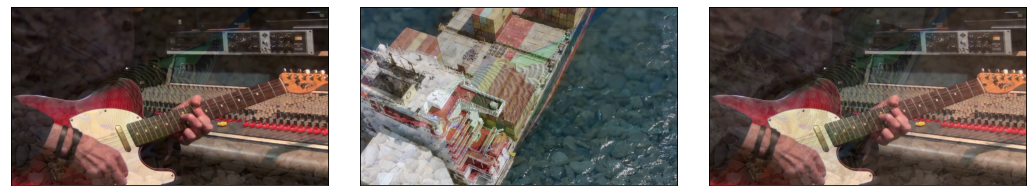

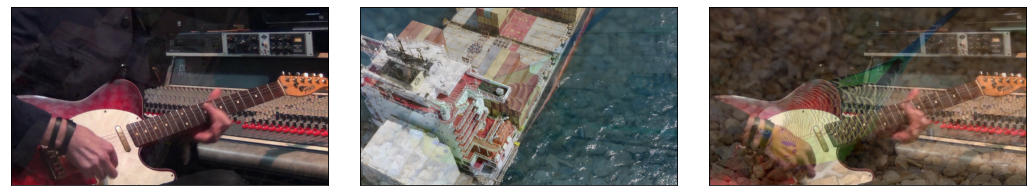

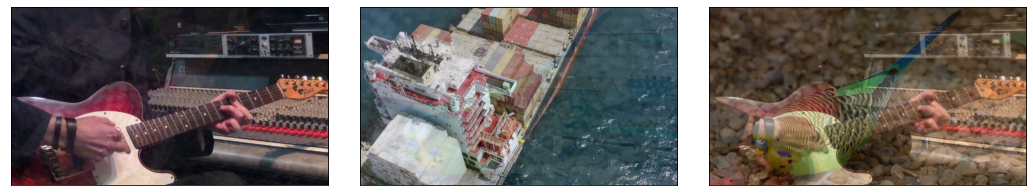

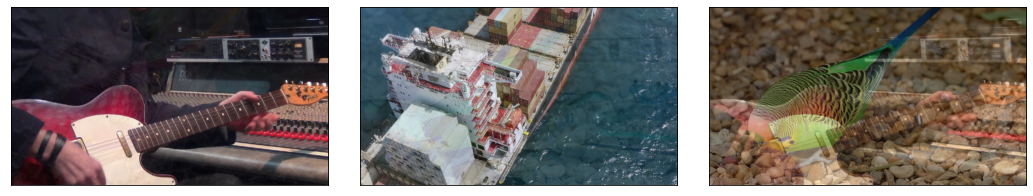

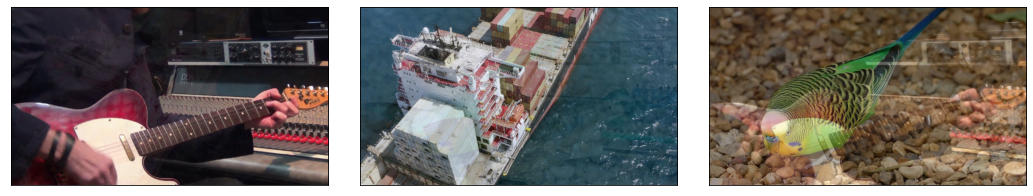

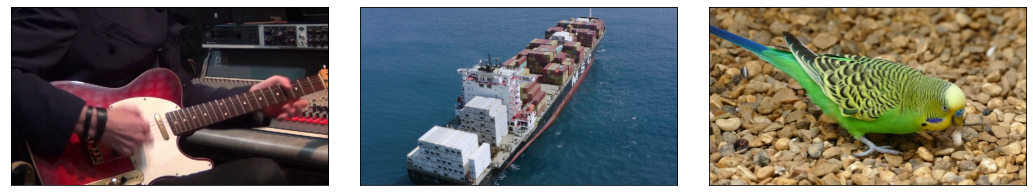

In [15]:
Subplot_RGB_images(Y_reconstructed_frames[1], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[25], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[50], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[80], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[100], imsize = [360, 640])
Subplot_RGB_images(Y_reconstructed_frames[-1], imsize = [360, 640])

# Save Seperated Videos

In [16]:
sep_dir = os.path.join(CURRENT_DIR, "Separated-Videos")
if not os.path.exists(sep_dir):
    os.mkdir(sep_dir)
sep1 = cv2.VideoWriter(os.path.join(sep_dir, "sep1.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
sep2 = cv2.VideoWriter(os.path.join(sep_dir, "sep2.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))
sep3 = cv2.VideoWriter(os.path.join(sep_dir, "sep3.avi"), cv2.VideoWriter_fourcc(*"MJPG"), 30, (640, 360))

for i in tqdm(range(FRAMES)):
    sep1.write(cv2.normalize(cv2.cvtColor(Y_reconstructed_frames[i][0].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
    sep2.write(cv2.normalize(cv2.cvtColor(Y_reconstructed_frames[i][1].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
    sep3.write(cv2.normalize(cv2.cvtColor(Y_reconstructed_frames[i][2].reshape(360, 640, 3).astype("float32"), cv2.COLOR_RGB2BGR), None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))
    
sep1.release()
sep2.release()
sep3.release()


100%|██████████| 300/300 [00:06<00:00, 45.37it/s]


# Creating the Final Video

In [17]:
DPI = 162

# Modified Subplot_RGB_Images()
def final_vid_subplot(I1, I2, I3, imsize = [360, 640], height = 6, width = 9, title = ''):
    n_images = 3
    images = (I1, I2, I3)
    titles = ("Source Video", "Mixture Video", "Recovered Video")
    
    fig, ax = plt.subplots(3, n_images, figsize = (9, 16)) 
    fig.patch.set_facecolor("black")
    fig.suptitle(title)
    fig.set_figheight(height)
    fig.set_figwidth(width) 
    for j in range(n_images):
        for i in range(n_images):
            Im = [images[j][i,:].reshape(imsize[0],imsize[1], 3) for i in range(n_images)]
            ax[j][i].set_title(f"{titles[j]} {i+1}", color="white", fontsize=15)
            ax[j][i].imshow(Im[i])
            ax[j][i].axes.xaxis.set_visible(False)
            ax[j][i].axes.yaxis.set_visible(False)
    plt.subplots_adjust(right=0.97,\
                    left=0.03,\
                    bottom=0.03,\
                    top=0.9,\
                    wspace=0.1,\
                    hspace=0.4)
    fig.dpi = DPI 
    return fig

In [18]:
final_vid = cv2.VideoWriter(
    os.path.join(CURRENT_DIR, "FINAL.avi"), 
    cv2.VideoWriter_fourcc(*"MJPG"), 30, (DPI * 9, DPI * 6)) # dpi * 9, dpi * 6

for i in tqdm(range(FRAMES)):
    fig = final_vid_subplot(S_plot_arr[i], X_plot_arr[i], Y_reconstructed_frames[i])
    plt.savefig(os.path.join(data_dir, f"FINAL-{i+1}.png"))

    img = Image.open(os.path.join(data_dir, f"FINAL-{i+1}.png"))
    rgb_img = img.convert('RGB')
    rgb_img.save(os.path.join(data_dir, f"FINAL-{i+1}.jpg"))
    os.remove(os.path.join(data_dir, f"FINAL-{i+1}.png"))
    
    final_vid.write(cv2.imread(os.path.join(data_dir, f"FINAL-{i+1}.jpg")))
    os.remove(os.path.join(data_dir, f"FINAL-{i+1}.jpg"))
    plt.close(fig)
final_vid.release()

100%|██████████| 300/300 [05:15<00:00,  1.05s/it]
